In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

In [2]:
import pqr

# Загрузка и предобработка данных

In [3]:
prices = pd.read_csv('factors/usa/usa_stocks.csv', index_col=0, parse_dates=True)

momentum = pqr.Factor(prices).look_back(12, 'dynamic').filter(mask=prices > 10).hold(12)
benchmark = pqr.Benchmark().from_stock_universe(prices, mask=prices > 10)

# Строим time-series факторную модель

In [4]:
portfolios = pqr.fit_time_series_factor_model(prices, momentum, threshold=0, better='more')

,losers,winners
"Total Return, %",1655.09,9415.7
"CAGR, %",6.21,10.05
"Mean Return, %",7.95,11.54
"Volatility, %",19.71,21.33
"Win Rate, %",56.22,61.65
"Maximum Drawdown, %",-47.72,-50.92
"VaR, %",-26.16,-21.64
"Expected Tail Loss, %",-42.27,-38.0
Rachev Ratio,1.14,1.2
Calmar Ratio,0.13,0.2


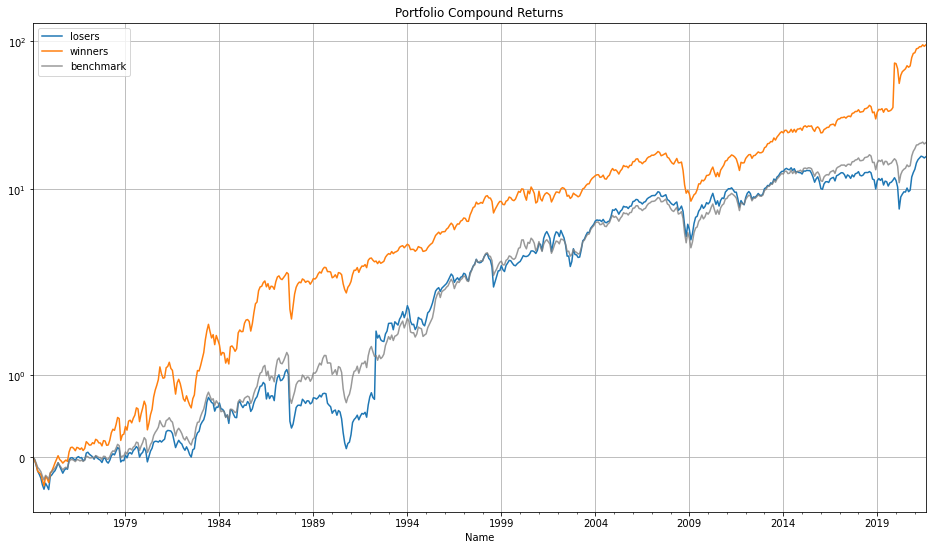

In [5]:
plt.yscale('symlog')
pqr.summary_tear_sheet(portfolios, benchmark)

# Строим quantile факторную модель с 5 квантилями

In [6]:
portfolios_q = pqr.fit_quantile_factor_model(prices, momentum, quantiles=5, better='more')

,winners,p2,p3,p4,losers
"Total Return, %",10304.56,5686.12,4652.58,2047.04,1957.04
"CAGR, %",10.25,8.9,8.45,6.66,6.56
"Mean Return, %",13.68,9.78,9.22,7.67,9.05
"Volatility, %",34.05,15.53,14.58,15.45,23.47
"Win Rate, %",59.72,61.82,61.65,61.12,56.04
"Maximum Drawdown, %",-52.8,-47.63,-46.52,-52.21,-55.71
"VaR, %",-32.48,-21.08,-20.37,-22.18,-31.36
"Expected Tail Loss, %",-47.53,-35.28,-33.12,-36.44,-49.06
Rachev Ratio,1.39,0.97,0.99,0.94,1.26
Calmar Ratio,0.19,0.19,0.18,0.13,0.12


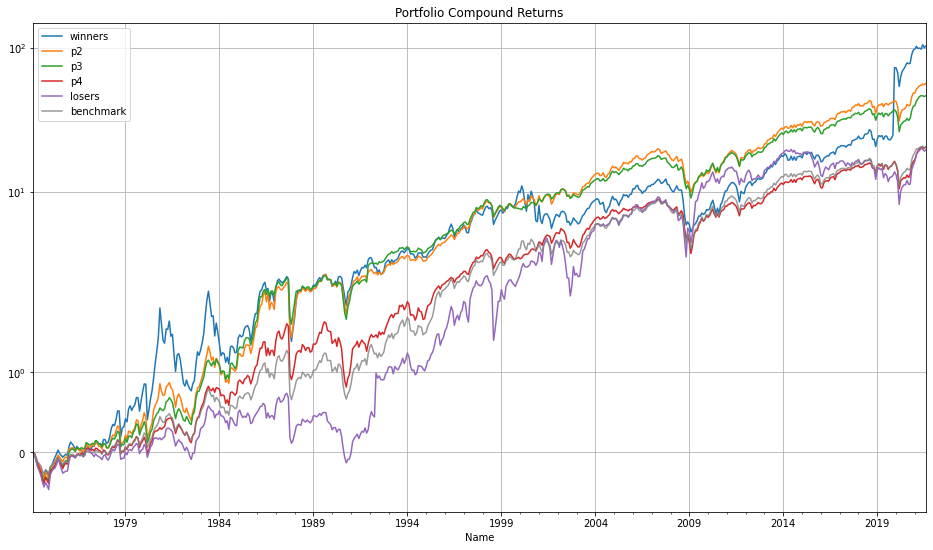

In [7]:
plt.yscale('symlog')
pqr.summary_tear_sheet(portfolios_q, benchmark)

# Пробуем prophet_test

Его суть заключается в том, что мы собираем идеальный портфель, а потом находим 2 метрики: 
1. отношение доходности портфеля к доходности идеального портфеля
2. разница доходности портфеля и идеального портфеля (грубо говоря недополученная прибыль)

In [8]:
ratio_winners, abs_diff_winners = pqr.prophet_test(prices, portfolios[1])
ratio_losers, abs_diff_losers = pqr.prophet_test(prices, portfolios[0])

<AxesSubplot:xlabel='Name'>

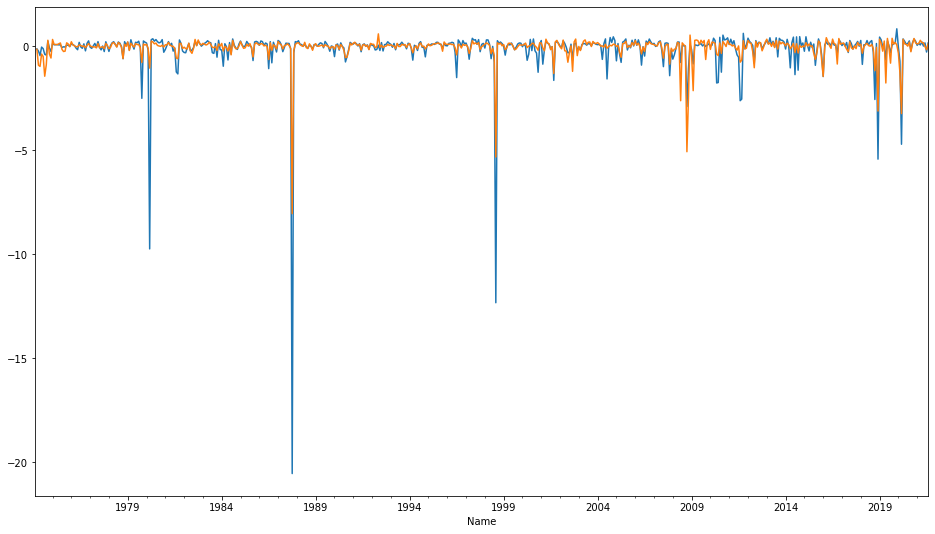

In [9]:
ratio_winners.plot()
ratio_losers.plot()

<AxesSubplot:xlabel='Name'>

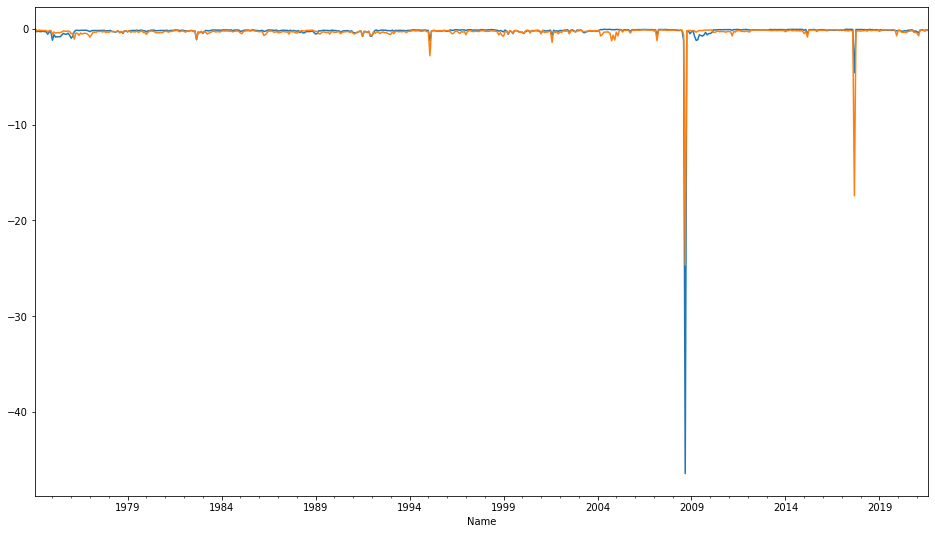

In [10]:
abs_diff_winners.plot()
abs_diff_losers.plot()

Результаты не очень получаются: за счет того, что у идеального портфеля слишком большая ежепериодная доходность, отношение колеблется около нуля (т.к. делим на относительно очень большое число), а абсолютная разница колеблется около 30% (в среднем именно такую доходность дает идеальный портфель с месячной ребалансировкой). К тому же, в кризисные периоды шипы на графике делают его непрезентабельным совсем.

# Double time-series momentum

Сначала строим 2 простых лонг-портфеля. Первый покупает акции, когда индекс растет, второй - **покупает**, когда индекс падает. Потом из них соберем аля-wml, и готово.

In [11]:
ts_long = pqr.Portfolio('double ts long')
# отбираем сначала все акции с положительным 12-месячным моментумом в портфель
ts_long.pick_by_factor(momentum, method='time-series', thresholds=(0, np.inf))
# потом убираем из лонга, если индекс имеет отрицательную доходность
ts_long.filter(benchmark.returns > 0)
ts_long.weigh_equally()
ts_long.allocate(prices)


# аналогично строим портфель шортов
ts_short = pqr.Portfolio('double ts short')
ts_short.pick_by_factor(momentum, method='time-series', thresholds=(-np.inf, 0))
ts_short.filter(benchmark.returns < 0)
ts_short.weigh_equally()
ts_short.allocate(prices)

Portfolio('double ts short')

<AxesSubplot:xlabel='Name'>

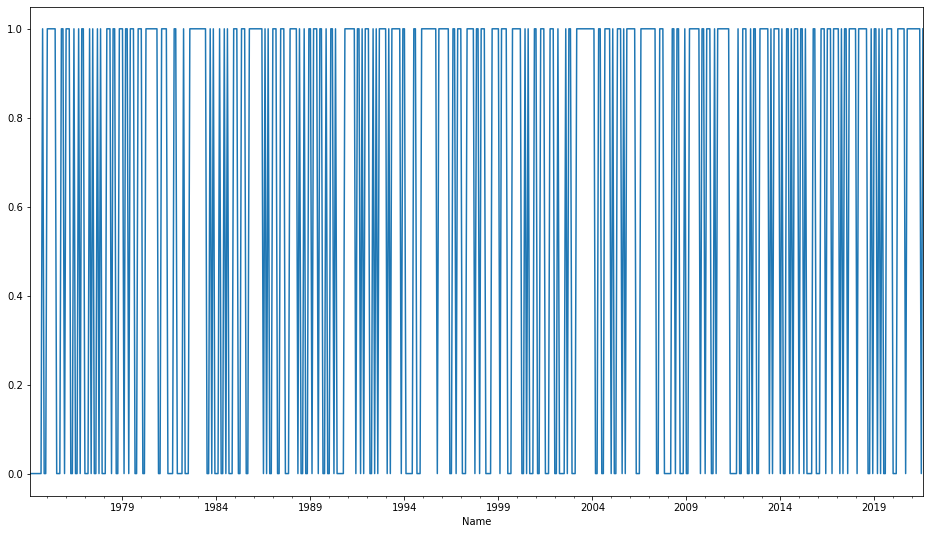

In [12]:
# удостоверимся, что мы то в рынке, то не в рынке
ts_long.weights.sum(axis=1).plot()

In [13]:
double_ts = pqr.Portfolio('double ts')
double_ts.pick_wml(ts_long, ts_short)
double_ts.weigh_equally()
double_ts.allocate(prices)

Portfolio('double ts')

,double ts,double ts long,double ts short
"Total Return, %",10951.7,13732.97,-65.1
"CAGR, %",10.39,10.92,-2.19
"Mean Return, %",12.42,11.48,-0.94
"Volatility, %",23.38,17.02,16.09
"Win Rate, %",60.95,39.93,18.39
"Maximum Drawdown, %",-60.87,-21.36,-73.85
"VaR, %",-21.4,-11.77,-23.83
"Expected Tail Loss, %",-42.22,-18.81,-40.21
Rachev Ratio,1.27,1.96,0.99
Calmar Ratio,0.17,0.51,-0.03


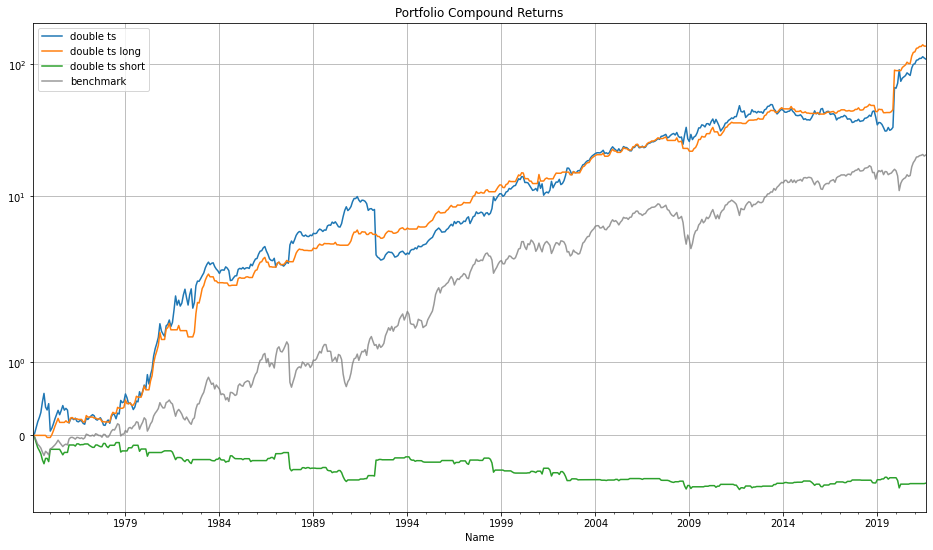

In [14]:
plt.yscale('symlog')
pqr.summary_tear_sheet([double_ts, ts_long, ts_short], benchmark)

Использование методики double time-series momentum действительно показало себя лучше простого моментума за счет тайминга, но есть подозрение, что с введением ограничения на шорты и комиссий, это уйдет, и получится либо такой же моментум, либо даже чуть хуже.